In [1]:
import os, json
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#pd.set_option("display.width", 500)  # adjusts total line width before wrapping
import numpy as np
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import matplotlib.pyplot as plt
import duckdb
from transformers import AutoTokenizer, AutoModel
import importlib
from sklearn.manifold import TSNE

conn = duckdb.connect('/srv/data/grela/grela_v0-3.duckdb', read_only=True)

In [2]:
# our own embedding functions
import helper_functions
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jupyter-vojta/notebooks/enemy-christianity/scripts/helper_functions.py'>

In [3]:
try:
    file_data = json.load(open(os.path.expanduser("~/ServiceAccountsKey.json")))
    # (2) transform the content into crendentials object
    credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
    scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
    gc = gspread.Client(auth=scoped_credentials)
    enemy_gs = gc.open_by_url("https://docs.google.com/spreadsheets/d/1ENbQuxY_U8W0sKHtiN348AS7KS9pxKjnbSg18KuUs7U/edit?usp=sharing")
except:
    pass

## Load annotated NT verses

In [4]:
biblical_verses = get_as_dataframe(enemy_gs.worksheet("biblical-verses"))
biblical_verses["chapter"] = biblical_verses["chapter"].astype(int).astype(str)
biblical_verses["verse"] = biblical_verses["verse"].astype(int).astype(str)

In [5]:
biblical_verses.shape

(645, 13)

In [6]:
biblical_verses.head(10)

,book_code,book_name,chapter,verse,primary_category,additional_categories,cat1_polemical terms,cat2_polemical terms,cat3_polemical terms,cat4_polemical terms,cat5_polemical terms,cat6_polemical terms,cat7_polemical terms
0,lagt_tlg0031.tlg013,1 Thessalonians,2,2,5.0,NaN,NaN,NaN,NaN,NaN,"ὑβρίζω, προπάσχω, ἀγών",NaN,NaN
1,lagt_tlg0031.tlg013,1 Thessalonians,2,3,2.0,NaN,NaN,"πλάνη, ἀκαθαρσία, δόλος",NaN,NaN,NaN,NaN,NaN
2,lagt_tlg0031.tlg013,1 Thessalonians,2,5,2.0,NaN,NaN,"κολακεία, πρόφασις, πλεονεξία",NaN,NaN,NaN,NaN,NaN
3,lagt_tlg0031.tlg013,1 Thessalonians,2,14,5.0,NaN,NaN,NaN,NaN,NaN,πάσχω,NaN,NaN
4,lagt_tlg0031.tlg013,1 Thessalonians,2,15,5.0,NaN,NaN,NaN,NaN,NaN,"ἀποκτείνω, ἐκδιώκω, ἐναντίος",NaN,NaN
5,lagt_tlg0031.tlg013,1 Thessalonians,2,16,5.0,7,NaN,NaN,NaN,NaN,"κωλύω, ἁμαρτία, ὀργή",NaN,NaN
6,lagt_tlg0031.tlg013,1 Thessalonians,2,18,7.0,5,NaN,NaN,NaN,NaN,NaN,NaN,ἐγκόπτω
7,lagt_tlg0031.tlg013,1 Thessalonians,4,3,4.0,NaN,NaN,NaN,NaN,πορνεία,NaN,NaN,NaN
8,lagt_tlg0031.tlg013,1 Thessalonians,4,5,4.0,NaN,NaN,NaN,NaN,ἐπιθυμία,NaN,NaN,NaN
9,lagt_tlg0031.tlg013,1 Thessalonians,4,6,2.0,1,ἔκδικος,ὑπερβαίνω,NaN,NaN,NaN,NaN,NaN


In [7]:
biblical_verses["chapterverse"] = biblical_verses.apply(lambda row: ".".join([row["chapter"], row["verse"]]), axis=1)
biblical_verses.rename({"book_code" :"grela_id"}, axis=1, inplace=True)

In [8]:
biblical_verses.columns

Index(['grela_id', 'book_name', 'chapter', 'verse', 'primary_category',
       'additional_categories', 'cat1_polemical terms', 'cat2_polemical terms',
       'cat3_polemical terms', 'cat4_polemical terms', 'cat5_polemical terms',
       'cat6_polemical terms', 'cat7_polemical terms', 'chapterverse'],
      dtype='object')

In [9]:
# we have to normalize!!!
helper_functions.normalize_greek("ἐντυγχάνω") == "ἐντυγχάνω"

True

In [10]:
polemical_terms_nt_dict = {}
for i in range(1,8): # for each column listing polemical terms
    col = f"cat{i}_polemical terms"
    terms_list_ser = biblical_verses.loc[biblical_verses[col].notnull(), col].apply(lambda x: x.split(", "))#%% md
    polemical_terms_nt_dict["cat" + str(i)] = set([helper_functions.normalize_greek(t) for l in terms_list_ser for t in l])

In [11]:
polemical_terms_nt_dict

{'cat1': {' διάβολος',
  'Βάαλ',
  'Βεελζεβούλ',
  'Γώγ',
  'Μαγώγ',
  'Μολόχ',
  'Νικολαΐτης',
  'Σατάν',
  'Σατανᾶς',
  'αἰών',
  'αἵρεσις',
  'αὐθάδης',
  'βέβηλος',
  'βασκαίνω',
  'βδέλυγμα',
  'βδελυκτός',
  'βδελύσσομαι',
  'βλάσφημος',
  'βλασφημέω',
  'βλασφημία',
  'γέεννα',
  'γενεαλογία',
  'γοητής',
  'γραώδης',
  'δίκη',
  'δαίμων',
  'δαιμονίζομαι',
  'δαιμόνιον',
  'διάβολος',
  'διακρίνω',
  'διαστρέφω',
  'διστάζω',
  'δράκων',
  'εἰδωλολάτρης',
  'εἰδωλολατρία',
  'εἰδωλόθυτον',
  'εἰκών',
  'εἴδωλον',
  'ζόφος',
  'θήρα',
  'θεοστυγής',
  'θηρίον',
  'θλῖψις',
  'θύμος',
  'καθεύδω',
  'κακολογέω',
  'κατάνυξις',
  'κατάρα',
  'καταδικάζω',
  'κατακλυσμός',
  'κατακρίνω',
  'καταναθεμα',
  'καταράομαι',
  'καταστροφή',
  'κατατομή',
  'καταφθείρω',
  'κατείδωλος',
  'καυστηριάζω',
  'κοινός',
  'κοινόω',
  'κολάζω',
  'κρίμα',
  'κρίνω',
  'κρίσις',
  'κόσμος',
  'λατρεύω',
  'μάγος',
  'μάταιος',
  'μαγεύω',
  'ματαιότης',
  'μεταλλάσσω',
  'μεταστρέφω',
  'μετατίθ

In [12]:
polemical_terms_nt_flat = []
for k, v in polemical_terms_nt_dict.items():
    polemical_terms_nt_flat.extend(v)
polemical_terms_nt_flat = list(set(polemical_terms_nt_flat))

In [13]:
len(polemical_terms_nt_flat)

636

## Ekthros coocurrents

In [19]:
all_freqs = get_as_dataframe(enemy_gs.worksheet("all_freqs"))
# change type to int
all_freqs["label"] = all_freqs["label"].fillna(-1).astype(int)#%%
all_freqs.sample(10)

,word,count,corpus,label,Zdenka_old_hand_label
2930,ἑτοῖμος,932.0,pagan_0_300,-1,NaN
3433,ναῦς,480.0,pagan_300_600,-1,NaN
374,προσεύχομαι,404.0,christian_0_300,-1,NaN
3242,μανθάνω,918.0,pagan_300_600,-1,NaN
142,ὀλίγος,912.0,christian_0_300,-1,NaN
2053,ψυχή,7784.0,pagan_0_300,-1,NaN
1326,πρόκειμαι,1014.0,christian_300_600,-1,NaN
2274,στρατηγός,2650.0,pagan_0_300,5,NaN
532,ὑποτάσσω,288.0,christian_0_300,-1,NaN
2028,γράφω,11612.0,pagan_0_300,-1,NaN


In [21]:
polemical_terms_coocs_dict = {}
for n in range(1,8):
    polemical_terms_coocs_dict["cat" + str(n)] = [helper_functions.normalize_greek(w) for w in all_freqs[all_freqs["label"] == n]["word"].tolist()]

In [22]:
polemical_terms_coocs_dict

{'cat1': ['δαίμων',
  'κρίνω',
  'διάβολος',
  'σκότος',
  'κολάζω',
  'κόλασις',
  'πλανάω',
  'πειράω',
  'ἀσεβής',
  'θηρίον',
  'αἵρεσις',
  'δαιμόνιον',
  'ἀφίστημι',
  'ἀρνέομαι',
  'ὄφις',
  'γνωστικός',
  'εἴδωλον',
  'ἀκάθαρτος',
  'ᾅδης',
  'ἀποστρέφω',
  'χωρίζω',
  'πλάνη',
  'ἀπιστέω',
  'ἄγαλμα',
  'διακρίνω',
  'ἄπιστος',
  'ἀπώλεια',
  'πειρασμός',
  'δράκων',
  'μάγος',
  'καθαιρέω',
  'βλασφημέω',
  'κρίμα',
  'ἄθεος',
  'λατρεύω',
  'φάρμακον',
  'φαντασία',
  'ἀντίκειμαι',
  'κρίνω',
  'δαίμων',
  'αἵρεσις',
  'χωρίζω',
  'φαντασία',
  'διάβολος',
  'πλανάω',
  'πειράω',
  'πλάνη',
  'διακρίνω',
  'σκότος',
  'καθαιρέω',
  'εἴδωλον',
  'τιμωρία',
  'ἀρνέομαι',
  'ἀσεβής',
  'ἀσέβεια',
  'θηρίον',
  'κόλασις',
  'ἄπιστος',
  'ἐναντιόομαι',
  'διαβάλλω',
  'ἀφίστημι',
  'παραιτέομαι',
  'κολάζω',
  'πειρασμός',
  'ἀποστρέφω',
  'ἀκάθαρτος',
  'ἡσσάομαι',
  'αἱρετικός',
  'ὄφις',
  'βλασφημία',
  'φάρμακον'],
 'cat2': ['φαῦλος',
  'ἀπατάω',
  'κρύπτω',
  'ψεῦδος',
  'ψ

## GreLa GNT tokens

In [23]:
query = """
    SELECT t.*, w.*
    FROM tokens t
    JOIN works w ON t.grela_id = w.grela_id
    WHERE w.grela_id LIKE 'lagt_tlg0031%'
"""

gnt_tokens = conn.execute(query).fetchdf()

In [24]:
len(gnt_tokens)

158318

In [25]:
gnt_tokens.head(5)

,sentence_id,grela_id,token_text,lemma,pos,char_start,char_end,token_id,ref,grela_source,...,noscemus_discipline,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,token_count,textsource
0,lagt_tlg0031.tlg005_749,lagt_tlg0031.tlg005,.,.,PUNCT,166,167,349296163,"{""div_chapter"": ""20"", ""div_section"": ""20.28""}",lagt,...,None,None,NaN,None,None,NaN,NaN,85.0,20679,glaux
1,lagt_tlg0031.tlg005_750,lagt_tlg0031.tlg005,ἐγὼ,ἐγώ,PRON,0,3,349296164,"{""div_chapter"": ""20"", ""div_section"": ""20.29""}",lagt,...,None,None,NaN,None,None,NaN,NaN,85.0,20679,glaux
2,lagt_tlg0031.tlg005_750,lagt_tlg0031.tlg005,οἶδα,οἶδα,VERB,4,8,349296165,"{""div_chapter"": ""20"", ""div_section"": ""20.29""}",lagt,...,None,None,NaN,None,None,NaN,NaN,85.0,20679,glaux
3,lagt_tlg0031.tlg005_750,lagt_tlg0031.tlg005,ὅτι,ὅτι,CCONJ,9,12,349296166,"{""div_chapter"": ""20"", ""div_section"": ""20.29""}",lagt,...,None,None,NaN,None,None,NaN,NaN,85.0,20679,glaux
4,lagt_tlg0031.tlg005_750,lagt_tlg0031.tlg005,εἰσελεύσονται,εἰσέρχομαι,VERB,13,26,349296167,"{""div_chapter"": ""20"", ""div_section"": ""20.29""}",lagt,...,None,None,NaN,None,None,NaN,NaN,85.0,20679,glaux


In [26]:
gnt_tokens.groupby("grela_id").size()

grela_id
lagt_tlg0031.tlg001    21010
lagt_tlg0031.tlg002    12998
lagt_tlg0031.tlg003    22410
lagt_tlg0031.tlg004    18143
lagt_tlg0031.tlg005    20679
lagt_tlg0031.tlg006     8191
lagt_tlg0031.tlg007     8079
lagt_tlg0031.tlg008     5165
lagt_tlg0031.tlg009     2613
lagt_tlg0031.tlg010     2701
lagt_tlg0031.tlg011     1873
lagt_tlg0031.tlg012     1803
lagt_tlg0031.tlg013     1677
lagt_tlg0031.tlg014      926
lagt_tlg0031.tlg015     1897
lagt_tlg0031.tlg016     1469
lagt_tlg0031.tlg017      778
lagt_tlg0031.tlg018      387
lagt_tlg0031.tlg019     5680
lagt_tlg0031.tlg020     2045
lagt_tlg0031.tlg021     1930
lagt_tlg0031.tlg022     1243
lagt_tlg0031.tlg023     2444
lagt_tlg0031.tlg024      281
lagt_tlg0031.tlg025      255
lagt_tlg0031.tlg026      528
lagt_tlg0031.tlg027    11113
dtype: int64

In [27]:
import ast
def extract_chapterverse(ref_str):
    ref = ast.literal_eval(ref_str) if isinstance(ref_str, str) else ref_str
    sec = ref.get("div_section")
    if "." not in sec:
        sec = "1." + sec
    return sec
gnt_tokens["chapterverse"] = gnt_tokens["ref"].apply(extract_chapterverse)

In [28]:
gnt_tokens[(gnt_tokens["chapterverse"].str.startswith("3.14")) & (gnt_tokens["grela_id"]=="lagt_tlg0031.tlg006")]

,sentence_id,grela_id,token_text,lemma,pos,char_start,char_end,token_id,ref,grela_source,...,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,token_count,textsource,chapterverse
12632,lagt_tlg0031.tlg006_68,lagt_tlg0031.tlg006,ὧν,ὅς,PRON,97,99,349303288,"{""div_chapter"": ""3"", ""div_section"": ""3.14""}",lagt,...,None,NaN,None,None,NaN,NaN,55.0,8191,glaux,3.14
12633,lagt_tlg0031.tlg006_68,lagt_tlg0031.tlg006,τὸ,ὁ,DET,100,102,349303289,"{""div_chapter"": ""3"", ""div_section"": ""3.14""}",lagt,...,None,NaN,None,None,NaN,NaN,55.0,8191,glaux,3.14
12634,lagt_tlg0031.tlg006_68,lagt_tlg0031.tlg006,στόμα,στόμα,NOUN,103,108,349303290,"{""div_chapter"": ""3"", ""div_section"": ""3.14""}",lagt,...,None,NaN,None,None,NaN,NaN,55.0,8191,glaux,3.14
12635,lagt_tlg0031.tlg006_68,lagt_tlg0031.tlg006,ἀρᾶς,ἀρά,NOUN,109,113,349303291,"{""div_chapter"": ""3"", ""div_section"": ""3.14""}",lagt,...,None,NaN,None,None,NaN,NaN,55.0,8191,glaux,3.14
12636,lagt_tlg0031.tlg006_68,lagt_tlg0031.tlg006,καὶ,καί,X,114,117,349303292,"{""div_chapter"": ""3"", ""div_section"": ""3.14""}",lagt,...,None,NaN,None,None,NaN,NaN,55.0,8191,glaux,3.14
12637,lagt_tlg0031.tlg006_68,lagt_tlg0031.tlg006,πικρίας,πικρία,NOUN,118,125,349303293,"{""div_chapter"": ""3"", ""div_section"": ""3.14""}",lagt,...,None,NaN,None,None,NaN,NaN,55.0,8191,glaux,3.14
12638,lagt_tlg0031.tlg006_68,lagt_tlg0031.tlg006,γέμει,γέμω,VERB,126,131,349303294,"{""div_chapter"": ""3"", ""div_section"": ""3.14""}",lagt,...,None,NaN,None,None,NaN,NaN,55.0,8191,glaux,3.14
12639,lagt_tlg0031.tlg006_68,lagt_tlg0031.tlg006,·,·,PUNCT,131,132,349303295,"{""div_chapter"": ""3"", ""div_section"": ""3.14""}",lagt,...,None,NaN,None,None,NaN,NaN,55.0,8191,glaux,3.14


In [29]:
gnt_tokens[gnt_tokens["grela_id"]=="lagt_tlg0031.tlg026"]

,sentence_id,grela_id,token_text,lemma,pos,char_start,char_end,token_id,ref,grela_source,...,title_short,emlap_noscemus_id,place_publication,place_geonames,author_viaf,title_viaf,date_random,token_count,textsource,chapterverse
111861,lagt_tlg0031.tlg026_0,lagt_tlg0031.tlg026,Ἰούδας,Ἰούδας,NOUN,0,6,349353365,"{""div_section"": ""1""}",lagt,...,None,NaN,None,None,NaN,NaN,91.0,528,glaux,1.1
111862,lagt_tlg0031.tlg026_0,lagt_tlg0031.tlg026,Ἰησοῦ,Ἰησοῦς,NOUN,7,12,349353366,"{""div_section"": ""1""}",lagt,...,None,NaN,None,None,NaN,NaN,91.0,528,glaux,1.1
111863,lagt_tlg0031.tlg026_0,lagt_tlg0031.tlg026,Χριστοῦ,Χριστός,NOUN,13,20,349353367,"{""div_section"": ""1""}",lagt,...,None,NaN,None,None,NaN,NaN,91.0,528,glaux,1.1
111864,lagt_tlg0031.tlg026_0,lagt_tlg0031.tlg026,δοῦλος,δοῦλος,NOUN,21,27,349353368,"{""div_section"": ""1""}",lagt,...,None,NaN,None,None,NaN,NaN,91.0,528,glaux,1.1
111865,lagt_tlg0031.tlg026_0,lagt_tlg0031.tlg026,",",",",PUNCT,27,28,349353369,"{""div_section"": ""1""}",lagt,...,None,NaN,None,None,NaN,NaN,91.0,528,glaux,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114432,lagt_tlg0031.tlg026_18,lagt_tlg0031.tlg026,τοὺς,ὁ,DET,235,239,349353888,"{""div_section"": ""25""}",lagt,...,None,NaN,None,None,NaN,NaN,91.0,528,glaux,1.25
114433,lagt_tlg0031.tlg026_18,lagt_tlg0031.tlg026,αἰῶνας,αἰών,NOUN,240,246,349353889,"{""div_section"": ""25""}",lagt,...,None,NaN,None,None,NaN,NaN,91.0,528,glaux,1.25
114434,lagt_tlg0031.tlg026_18,lagt_tlg0031.tlg026,·,·,PUNCT,246,247,349353890,"{""div_section"": ""25""}",lagt,...,None,NaN,None,None,NaN,NaN,91.0,528,glaux,1.25
114435,lagt_tlg0031.tlg026_19,lagt_tlg0031.tlg026,ἀμήν,ἀμήν,INTJ,0,4,349353891,"{""div_section"": ""25""}",lagt,...,None,NaN,None,None,NaN,NaN,91.0,528,glaux,1.25


In [30]:
def _reconstruct_by_offsets(g: pd.DataFrame) -> str:
    g = g.sort_values(["char_start", "char_end"])
    out = []
    prev_end = None
    for _, r in g.iterrows():
        s, e = int(r["char_start"]), int(r["char_end"])
        tok = str(r["token_text"])
        if prev_end is None:
            # first token of the verse
            out.append(tok)
        else:
            if s >= prev_end:
                # same segment: insert exact gap (could be zero)
                if s > prev_end:
                    out.append(" " * (s - prev_end))
            else:
                # offset reset → new segment (likely new sentence); join with single space
                out.append(" ")
            out.append(tok)
        prev_end = e
    return "".join(out).lstrip()  # remove any leading spaces if verse starts mid-sentence


def reconstruct_verse(g: pd.DataFrame) -> pd.Series:
    verse_text = _reconstruct_by_offsets(g)
    token_dicts = g.sort_values(["char_start", "char_end"]).to_dict(orient="records")
    return pd.Series({
        "verse_text": verse_text,
        "tokens": token_dicts
    })


# group by grela_id + existing chapterverse
verses = (
    gnt_tokens
    .groupby(["grela_id", "chapterverse"], sort=False)
    .apply(reconstruct_verse)
    .reset_index()
)

print(verses.shape)

(7940, 4)


/tmp/ipykernel_3071248/2046339294.py:37: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(reconstruct_verse)


In [31]:
verses[verses["grela_id"]=="lagt_tlg0031.tlg026"]

,grela_id,chapterverse,verse_text,tokens
5802,lagt_tlg0031.tlg026,1.1,"Ἰούδας Ἰησοῦ Χριστοῦ δοῦλος, ἀδελφὸς δὲ Ἰακώβου, τοῖς ἐν θεῷ πατρὶ ἠγαπημένοις καὶ Ἰησοῦ Χριστῷ τετηρημένοις κλητοῖς·","[{'sentence_id': 'lagt_tlg0031.tlg026_0', 'grela_id': 'lagt_tlg0031.tlg026', 'token_text': 'Ἰούδας', 'lemma': 'Ἰούδας', 'pos': 'NOUN', 'char_start': 0, 'char_end': 6, 'token_id': 349353365, 'ref':..."
5803,lagt_tlg0031.tlg026,1.2,ἔλεος ὑμῖν καὶ εἰρήνη καὶ ἀγάπη πληθυνθείη.,"[{'sentence_id': 'lagt_tlg0031.tlg026_1', 'grela_id': 'lagt_tlg0031.tlg026', 'token_text': 'ἔλεος', 'lemma': 'ἔλεος', 'pos': 'NOUN', 'char_start': 0, 'char_end': 5, 'token_id': 349353385, 'ref': '..."
5804,lagt_tlg0031.tlg026,1.3,"ἀγαπητοί, πᾶσαν σπουδὴν ποιούμενος γράφειν ὑμῖν περὶ τῆς κοινῆς ἡμῶν σωτηρίας ἀνάγκην ἔσχον γράψαι ὑμῖν παρακαλῶν ἐπαγωνίζεσθαι τῇ ἅπαξ παραδοθείσῃ τοῖς ἁγίοις πίστει.","[{'sentence_id': 'lagt_tlg0031.tlg026_2', 'grela_id': 'lagt_tlg0031.tlg026', 'token_text': 'ἀγαπητοί', 'lemma': 'ἀγαπητός', 'pos': 'ADJ', 'char_start': 0, 'char_end': 8, 'token_id': 349353393, 're..."
5805,lagt_tlg0031.tlg026,1.4,"παρεισέδυσαν γάρ τινες ἄνθρωποι, οἱ πάλαι προγεγραμμένοι εἰς τοῦτο τὸ κρίμα, ἀσεβεῖς, τὴν τοῦ θεοῦ ἡμῶν χάριτα μετατιθέντες εἰς ἀσέλγειαν καὶ τὸν μόνον δεσπότην καὶ κύριον ἡμῶν Ἰησοῦν Χριστὸν ἀρνο...","[{'sentence_id': 'lagt_tlg0031.tlg026_3', 'grela_id': 'lagt_tlg0031.tlg026', 'token_text': 'παρεισέδυσαν', 'lemma': 'παρεισδύνω', 'pos': 'VERB', 'char_start': 0, 'char_end': 12, 'token_id': 349353..."
5806,lagt_tlg0031.tlg026,1.5,"ὑπομνῆσαι δὲ ὑμᾶς βούλομαι, εἰδότας ἅπαξ πάντα, ὅτι κύριος λαὸν ἐκ γῆς Αἰγύπτου σώσας τὸ δεύτερον τοὺς μὴ πιστεύσαντες ἀπώλεσεν,","[{'sentence_id': 'lagt_tlg0031.tlg026_4', 'grela_id': 'lagt_tlg0031.tlg026', 'token_text': 'ὑπομνῆσαι', 'lemma': 'ὑπομιμνῄσκω', 'pos': 'VERB', 'char_start': 0, 'char_end': 9, 'token_id': 349353452..."
5807,lagt_tlg0031.tlg026,1.6,ἀγγέλους τε τοὺς μὴ τηρήσαντας τὴν ἑαυτῶν ἀρχὴν ἀλλὰ ἀπολιπόντας τὸ ἴδιον οἰκητήριον εἰς κρίσιν μεγάλης ἡμέρας δεσμοῖς ἀϊδίοις ὑπὸ ζόφον τετήρηκεν·,"[{'sentence_id': 'lagt_tlg0031.tlg026_4', 'grela_id': 'lagt_tlg0031.tlg026', 'token_text': 'ἀγγέλους', 'lemma': 'ἄγγελος', 'pos': 'NOUN', 'char_start': 129, 'char_end': 137, 'token_id': 349353475,..."
5808,lagt_tlg0031.tlg026,1.7,"ὡς Σόδομα καὶ Γόμορρα καὶ αἱ περὶ αὐτὰς πόλεις, τὸν ὅμοιον τρόπον τούτοις ἐκπορνεύσασαι καὶ ἀπελθοῦσαι ὀπίσω σαρκὸς ἑτέρας, πρόκεινται δεῖγμα πυρὸς αἰωνίου δίκην ὑπέχουσαι.","[{'sentence_id': 'lagt_tlg0031.tlg026_5', 'grela_id': 'lagt_tlg0031.tlg026', 'token_text': 'ὡς', 'lemma': 'ὡς', 'pos': 'CCONJ', 'char_start': 0, 'char_end': 2, 'token_id': 349353498, 'ref': '{""div..."
5928,lagt_tlg0031.tlg026,1.8,"ὁμοίως μέντοι καὶ οὗτοι ἐνυπνιαζόμενοι σάρκα μὲν μιαίνουσιν, κυριότητα δὲ ἀθετοῦσιν, δόξας δὲ βλασφημοῦσιν.","[{'sentence_id': 'lagt_tlg0031.tlg026_6', 'grela_id': 'lagt_tlg0031.tlg026', 'token_text': 'ὁμοίως', 'lemma': 'ὅμοιος', 'pos': 'ADV', 'char_start': 0, 'char_end': 6, 'token_id': 349353526, 'ref': ..."
5929,lagt_tlg0031.tlg026,1.9,"ὁ δὲ Μιχαὴλ ὁ ἀρχάγγελος, ὅτε τῷ διαβόλῳ διακρινόμενος διελέγετο περὶ τοῦ Μωϋσέως σώματος, οὐκ ἐτόλμησεν κρίσιν ἐπενεγκεῖν βλασφημίας, ἀλλὰ εἶπεν, ἐπιτιμήσαι σοι κύριος.","[{'sentence_id': 'lagt_tlg0031.tlg026_7', 'grela_id': 'lagt_tlg0031.tlg026', 'token_text': 'ὁ', 'lemma': 'ὁ', 'pos': 'DET', 'char_start': 0, 'char_end': 1, 'token_id': 349353543, 'ref': '{""div_sec..."
5930,lagt_tlg0031.tlg026,1.10,"οὗτοι δὲ ὅσα μὲν οὐκ οἴδασιν βλασφημοῦσιν, ὅσα δὲ φυσικῶς ὡς τὰ ἄλογα ζῷα ἐπίστανται, ἐν τούτοις φθείρονται.","[{'sentence_id': 'lagt_tlg0031.tlg026_8', 'grela_id': 'lagt_tlg0031.tlg026', 'token_text': 'οὗτοι', 'lemma': 'οὗτος', 'pos': 'PRON', 'char_start': 0, 'char_end': 5, 'token_id': 349353572, 'ref': '..."


## Unpolemical verses sample generation

In [32]:
def get_unpolemical_verses(tokens):
    return all(token["lemma"] not in polemical_terms_nt_flat for token in tokens)
verses["unpolemical"] = verses["tokens"].apply(get_unpolemical_verses)

In [100]:
len(verses)

7940

In [33]:
verses["unpolemical"].sum()

np.int64(3249)

In [34]:
verses_unpolemical_sample = verses[verses["unpolemical"]].sample(1000, random_state=42)

In [35]:
set_with_dataframe(enemy_gs.add_worksheet("verses_unpolemical_sample1000", 1,1), verses_unpolemical_sample)

In [36]:
verses_unpolemical_sample.to_parquet("../data/verses_unpolemical_sample.parquet")

## Merge annptated verses with GreLa GNT text/tokens

In [37]:
# left join biblical_verses with verse texts
biblical_with_texts = (
    biblical_verses
    .merge(
        verses[["grela_id","chapterverse","verse_text", "tokens"]],
        on=["grela_id","chapterverse"],
        how="left"
    )
)

In [38]:
biblical_with_texts

,grela_id,book_name,chapter,verse,primary_category,additional_categories,cat1_polemical terms,cat2_polemical terms,cat3_polemical terms,cat4_polemical terms,cat5_polemical terms,cat6_polemical terms,cat7_polemical terms,chapterverse,verse_text,tokens
0,lagt_tlg0031.tlg013,1 Thessalonians,2,2,5.0,NaN,NaN,NaN,NaN,NaN,"ὑβρίζω, προπάσχω, ἀγών",NaN,NaN,2.2,ἀλλὰ προπαθόντες καὶ ὑβρισθέντες καθὼς οἴδατε ἐν Φιλίπποις ἐπαρρησιασάμεθα ἐν τῷ θεῷ ἡμῶν λαλῆσαι πρὸς ὑμᾶς τὸ εὐαγγέλιον τοῦ θεοῦ ἐν πολλῷ ἀγῶνι.,"[{'sentence_id': 'lagt_tlg0031.tlg013_6', 'grela_id': 'lagt_tlg0031.tlg013', 'token_text': 'ἀλλὰ', 'lemma': 'ἀλλά', 'pos': 'X', 'char_start': 79, 'char_end': 83, 'token_id': 349332604, 'ref': '{""d..."
1,lagt_tlg0031.tlg013,1 Thessalonians,2,3,2.0,NaN,NaN,"πλάνη, ἀκαθαρσία, δόλος",NaN,NaN,NaN,NaN,NaN,2.3,"ἡ γὰρ παράκλησις ἡμῶν οὐκ ἐκ πλάνης οὐ δὲ ἐξ ἀκαθαρσίας οὐ δὲ ἐν δόλῳ,","[{'sentence_id': 'lagt_tlg0031.tlg013_7', 'grela_id': 'lagt_tlg0031.tlg013', 'token_text': 'ἡ', 'lemma': 'ὁ', 'pos': 'DET', 'char_start': 0, 'char_end': 1, 'token_id': 349332628, 'ref': '{""div_cha..."
2,lagt_tlg0031.tlg013,1 Thessalonians,2,5,2.0,NaN,NaN,"κολακεία, πρόφασις, πλεονεξία",NaN,NaN,NaN,NaN,NaN,2.5,"οὔ τε γάρ ποτε ἐν λόγῳ κολακίας ἐγενήθημεν, καθὼς οἴδατε, οὔ τε ἐν προφάσει πλεονεξίας, θεὸς μάρτυς,","[{'sentence_id': 'lagt_tlg0031.tlg013_8', 'grela_id': 'lagt_tlg0031.tlg013', 'token_text': 'οὔ', 'lemma': 'οὐ', 'pos': 'ADV', 'char_start': 0, 'char_end': 2, 'token_id': 349332668, 'ref': '{""div_c..."
3,lagt_tlg0031.tlg013,1 Thessalonians,2,14,5.0,NaN,NaN,NaN,NaN,NaN,πάσχω,NaN,NaN,2.14,"ὑμεῖς γὰρ μιμηταὶ ἐγενήθητε, ἀδελφοί, τῶν ἐκκλησιῶν τοῦ θεοῦ τῶν οὐσῶν ἐν τῇ Ἰουδαίᾳ ἐν Χριστῷ Ἰησοῦ, ὅτι τὰ αὐτὰ ἐπάθετε καὶ ὑμεῖς ὑπὸ τῶν ἰδίων συμφυλετῶν καθὼς καὶ αὐτοὶ ὑπὸ τῶν Ἰουδαίων,","[{'sentence_id': 'lagt_tlg0031.tlg013_14', 'grela_id': 'lagt_tlg0031.tlg013', 'token_text': 'ὑμεῖς', 'lemma': 'σύ', 'pos': 'PRON', 'char_start': 0, 'char_end': 5, 'token_id': 349332869, 'ref': '{""..."
4,lagt_tlg0031.tlg013,1 Thessalonians,2,15,5.0,NaN,NaN,NaN,NaN,NaN,"ἀποκτείνω, ἐκδιώκω, ἐναντίος",NaN,NaN,2.15,"τῶν καὶ τὸν κύριον ἀποκτεινάντων Ἰησοῦν καὶ τοὺς προφήτας, καὶ ἡμᾶς ἐκδιωξάντων, καὶ θεῷ μὴ ἀρεσκόντων, καὶ πᾶσιν ἀνθρώποις ἐναντίων,","[{'sentence_id': 'lagt_tlg0031.tlg013_14', 'grela_id': 'lagt_tlg0031.tlg013', 'token_text': 'τῶν', 'lemma': 'ὁ', 'pos': 'DET', 'char_start': 191, 'char_end': 194, 'token_id': 349332906, 'ref': '{""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,lagt_tlg0031.tlg001,Matthew,27,30,5.0,NaN,NaN,NaN,NaN,NaN,"ἐμπτύω, κάλαμος, τύπτω",NaN,NaN,27.30,καὶ ἐμπτύσαντες εἰς αὐτὸν ἔλαβον τὸν κάλαμον καὶ ἔτυπτον εἰς τὴν κεφαλὴν αὐτοῦ.,"[{'sentence_id': 'lagt_tlg0031.tlg001_1498', 'grela_id': 'lagt_tlg0031.tlg001', 'token_text': 'καὶ', 'lemma': 'καί', 'pos': 'X', 'char_start': 31, 'char_end': 34, 'token_id': 349226693, 'ref': '{""..."
641,lagt_tlg0031.tlg001,Matthew,27,31,5.0,NaN,NaN,NaN,NaN,NaN,"ἐμπαίζω, σταυρόω",NaN,NaN,27.31,"καὶ ὅτε ἐνέπαιξαν αὐτῷ, ἐκδύσαντες αὐτὸν τὴν χλαμύδα ἐνέδυσαν αὐτὸν τὰ ἱμάτια αὐτοῦ, καὶ ἀπήγαγον αὐτὸν εἰς τὸ σταυρῶσαι.","[{'sentence_id': 'lagt_tlg0031.tlg001_1499', 'grela_id': 'lagt_tlg0031.tlg001', 'token_text': 'καὶ', 'lemma': 'καί', 'pos': 'ADV', 'char_start': 0, 'char_end': 3, 'token_id': 349226707, 'ref': '{""..."
642,lagt_tlg0031.tlg001,Matthew,27,35,5.0,NaN,NaN,NaN,NaN,NaN,σταυρόω,NaN,NaN,27.35,"σταυρώσαντες δὲ αὐτὸν διεμερίσαντο τὰ ἱμάτια αὐτοῦ βαλόντες κλῆρον,","[{'sentence_id': 'lagt_tlg0031.tlg001_1504', 'grela_id': 'lagt_tlg0031.tlg001', 'token_text': 'σταυρώσαντες', 'lemma': 'σταυρόω', 'pos': 'VERB', 'char_start': 0, 'char_end': 12, 'token_id': 349226..."
643,lagt_tlg0031.tlg001,Matthew,27,39,1.0,NaN,βλασφημέω,NaN,NaN,NaN,NaN,NaN,NaN,27.39,"οἱ δὲ παραπορευόμενοι ἐβλασφήμουν αὐτὸν, κινοῦντες τὰς κεφαλὰς αὐτῶν","[{'sentence_id': 'lagt_tlg0031.tlg001_1508', 'grela_id': 'lagt_tlg0031.tlg001', 'token_text': 'οἱ', 'lemma': 'ὁ', 'pos': 'DET', 'char_start': 0, 'char_end': 2, 'token_id': 34922682

In [39]:
len(biblical_with_texts)

645

In [40]:
biblical_with_texts[biblical_with_texts["verse_text"].isna()]

,grela_id,book_name,chapter,verse,primary_category,additional_categories,cat1_polemical terms,cat2_polemical terms,cat3_polemical terms,cat4_polemical terms,cat5_polemical terms,cat6_polemical terms,cat7_polemical terms,chapterverse,verse_text,tokens
574,lagt_tlg0031.tlg001,Matthew,23,14,2.0,"1, 6",κρίμα,ὑποκριτής,NaN,NaN,NaN,"Φαρισαῖος, γραμματεύς",NaN,23.14,NaN,NaN


In [41]:
biblical_with_texts[biblical_with_texts["verse_text"].isna()]

,grela_id,book_name,chapter,verse,primary_category,additional_categories,cat1_polemical terms,cat2_polemical terms,cat3_polemical terms,cat4_polemical terms,cat5_polemical terms,cat6_polemical terms,cat7_polemical terms,chapterverse,verse_text,tokens
574,lagt_tlg0031.tlg001,Matthew,23,14,2.0,"1, 6",κρίμα,ὑποκριτής,NaN,NaN,NaN,"Φαρισαῖος, γραμματεύς",NaN,23.14,NaN,NaN


In [42]:
biblical_with_texts = biblical_with_texts[biblical_with_texts["verse_text"].notna()].copy()
biblical_with_texts = biblical_with_texts[biblical_with_texts["primary_category"].notna()].copy()
len(biblical_with_texts)

643

## Merge polemical and unpolemical

In [43]:
verses_merged = pd.concat([biblical_with_texts, verses_unpolemical_sample], ignore_index=True)#%% md


In [44]:
len(verses_merged)

1643

In [45]:
verses_merged["lemmatized_sentence"] = verses_merged["tokens"].apply(lambda x: " ".join([t["lemma"] for t in x if t["pos"] in ["NOUN", "VERB", "PROPN", "ADJ"]]))

In [46]:
verses_merged["lemmatized_sentence"][:10].tolist()

['προπάσχω ὑβρίζω οἶδα Φίλιπποι παρρησιάζομαι θεός λαλέω εὐαγγέλιον θεός πολύς ἀγών',
 'παράκλησις πλάνη ἀκαθαρσία δόλος',
 'λόγος κολακεία γίγνομαι οἶδα πρόφασις πλεονεξία θεός μάρτυς',
 'μιμητής γίγνομαι ἀδελφός ἐκκλησία θεός εἰμί Ἰουδαία Χριστός Ἰησοῦς πάσχω ἴδιος συμφυλέτης Ἰουδαῖος',
 'κύριος ἀποκτείνω Ἰησοῦς προφήτης ἐκδιώκω θεός ἀρέσκω πᾶς ἄνθρωπος ἐναντίος',
 'φθάνω ὀργή τέλος κωλύω ἔθνος λαλέω σῴζω ἀναπληρόω ἁμαρτία',
 'ἐθέλω ἔρχομαι Παῦλος ἐγκόπτω Σατανᾶς',
 'εἰμί θέλημα θεός ἁγιασμός ἀπέχω πορνεία',
 'πάθος ἐπιθυμία ἔθνος οἶδα θεός',
 'ὑπερβαίνω πλεονεκτέω πρᾶγμα ἀδελφός ἔκδικος κύριος πᾶς προλέγω διαμαρτύρομαι']

## Sentence embeddings

In [47]:
tokenizer_agbert = AutoTokenizer.from_pretrained("pranaydeeps/Ancient-Greek-BERT")
model_agbert = AutoModel.from_pretrained("pranaydeeps/Ancient-Greek-BERT")

In [48]:
# Compute embeddings
device = "cpu"
emb_matrix = helper_functions.bert_sentence_embeddings(
    list(verses_merged["verse_text"].apply(lambda text: helper_functions.normalize_greek(text, strip_diacritics=True))),
    tokenizer=tokenizer_agbert,
    model=model_agbert,
    device=device,
    batch_size=32,           # adjust for your GPU/CPU RAM
    max_length=tokenizer_agbert.model_max_length,
    l2_normalize=True,       # set False if you prefer raw vectors
)

verses_merged["sent_emb_agbert"] = [emb for emb in emb_matrix]

In [49]:
# Compute embeddings
device = "cpu"
emb_matrix = helper_functions.bert_sentence_embeddings(
    list(verses_merged["lemmatized_sentence"].apply(lambda text: helper_functions.normalize_greek(text, strip_diacritics=True))),
    tokenizer=tokenizer_agbert,
    model=model_agbert,
    device=device,
    batch_size=32,           # adjust for your GPU/CPU RAM
    max_length=tokenizer_agbert.model_max_length,
    l2_normalize=True,       # set False if you prefer raw vectors
)

verses_merged["lem_sent_emb_agbert"] = [emb for emb in emb_matrix]

In [50]:
verses_merged["primary_category"] = (
    verses_merged["primary_category"].astype("Int64")
)

In [53]:
verses_merged["primary_category"] = verses_merged["primary_category"].fillna(-1)

In [ ]:
verses_merged.groupby("primary_category").size()

In [55]:
verses_merged["unpolemical"] = verses_merged["unpolemical"].fillna(False)

/tmp/ipykernel_3071248/3689619302.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  verses_merged["unpolemical"] = verses_merged["unpolemical"].fillna(False)


In [56]:
verses_merged.groupby("unpolemical").size()

unpolemical
False     643
True     1000
dtype: int64

In [57]:
verses_merged.to_parquet("../data/verses_merged.parquet")

In [58]:
def plot_tsne(df, emb_col, class_col, title="tSNE", perplexity=10):
    # 1) Stack your embeddings into a 2D array
    X = np.stack(df[emb_col].to_numpy())  # shape (n, hidden_size)

    # 2) Dimensionality reduction (to 2D)
    tsne = TSNE(
        n_components=2,
        random_state=42,
        init="random",
        learning_rate="auto",
        perplexity=perplexity,
    )
    X_2d = tsne.fit_transform(X)

    # 3) Add to your DataFrame for convenience
    df["x"] = X_2d[:,0]
    df["y"] = X_2d[:,1]

    # 4) Create the figure and axes explicitly
    fig, ax = plt.subplots(figsize=(10,7))
    categories = df[class_col].unique()

    for cat in categories:
        subset = df[df[class_col] == cat]
        ax.scatter(subset["x"], subset["y"], label=cat, alpha=0.7)

    ax.legend(title="Polemical Category")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.set_title(title)

    return fig

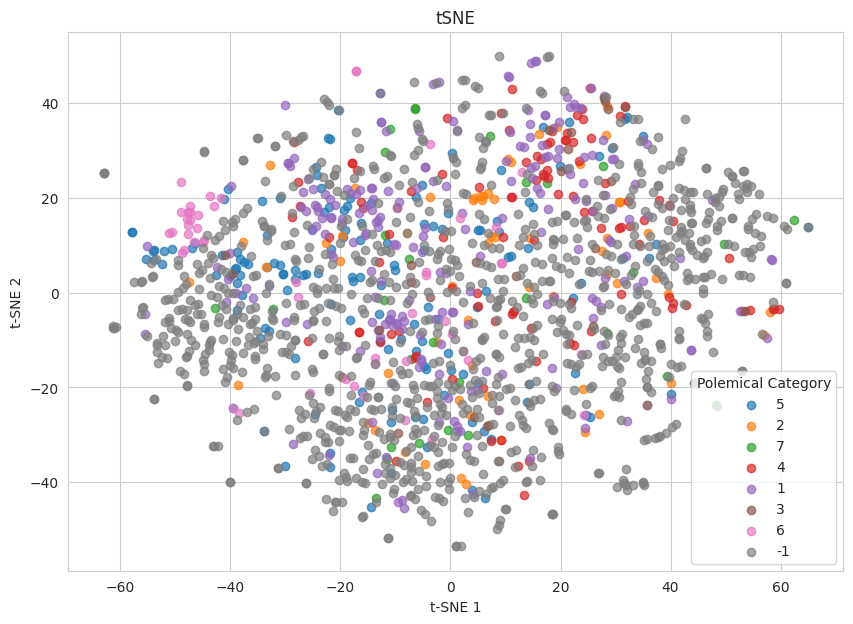

In [59]:
fig = plot_tsne(verses_merged, "sent_emb_agbert", "primary_category", perplexity=15)

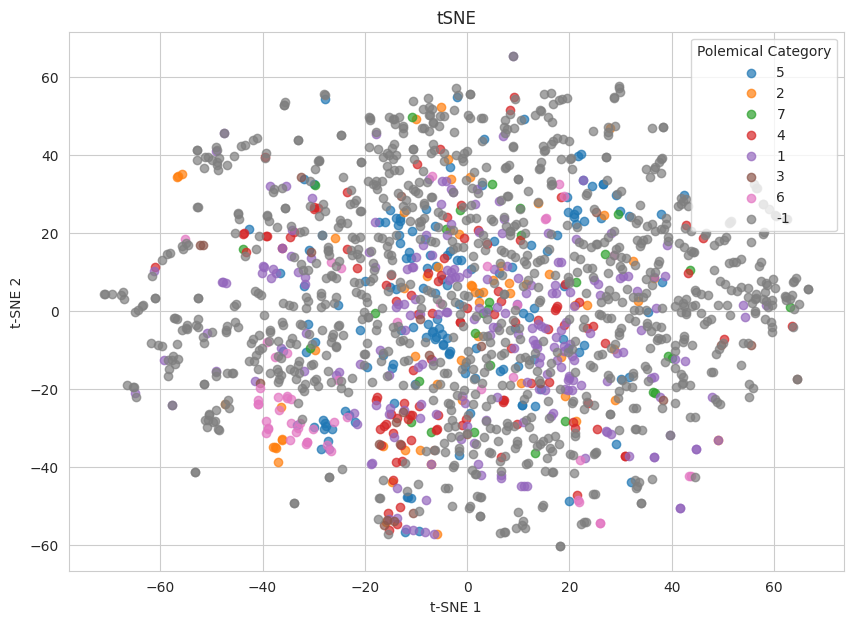

In [60]:
fig = plot_tsne(verses_merged, "lem_sent_emb_agbert", "primary_category", perplexity=10)


In [61]:
verses_merged.to_parquet("../data/verses_merged.parquet")